# Imports and Definitions

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import os
import shutil
import csv
from datetime import datetime
from google.colab import drive
from google.colab import files

In [2]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [3]:
def create_csv(results, results_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [4]:
def shuffle_validation_weighted(base_dir, split = 0.2, reset = False):
    # Create validation_set weighted on number of occurrences in training_set
    train_dir = os.path.join(base_dir, 'training')
    valid_dir = os.path.join(base_dir, 'validation')

    if not reset:
        # First identify training and validation dir
        if not os.path.exists(valid_dir):
            os.makedirs(valid_dir)

        # Count elements in each dir in training
        class_and_card = {name: len(os.listdir(os.path.join(train_dir, name))) for name in os.listdir(train_dir) if
                          os.path.join(train_dir, name)}

        print(class_and_card)
        # Get images per class wrt total images
        class_and_card_validation = {name: int(class_and_card[name] * split) for name in class_and_card}

        print(class_and_card_validation)
        # Select images to move
        for key, item in class_and_card_validation.items():
            source_dir = os.path.join(train_dir, key)
            images = os.listdir(source_dir)
            np.random.shuffle(images)
            target_dir = os.path.join(valid_dir, key)
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            for i in range(item):
                shutil.move(os.path.join(source_dir, images[i]), target_dir)
    else:
        # Restore initial state
        # For each class, move images to train_dir in respective folders
        classes = [name for name in os.listdir(valid_dir)]
        for class_name in classes:
            source_dir = os.path.join(valid_dir, class_name)
            images = os.listdir(source_dir)
            target_dir = os.path.join(train_dir, class_name)
            for img in images:
                shutil.move(os.path.join(source_dir, img), target_dir)

# Hyperparameters and Callbacks

In [5]:
# We executed a scoped GridSearch on the following parameters
# Dense Layers -> [0, 1, 2, 3] (tested parameters)
# Neurons Number -> [256, 512, 1024]
# Image Size -> [224 (default)] (same for heigth and width)
# Batch Size -> [8, 16, 32]
# Valid Percentage -> [0.2]
# Starting Learning Rate -> [1e-3, 1e-4]
# LR1 values -> [0, 0.001, 0.0001]
# LR2 values -> [0, 0.001, 0.0001]
# Below we have the best results

img_w, img_h = 224, 224
num_classes = 3

name = "efficientnetb0"
preprocessing = tf.keras.applications.efficientnet.preprocess_input
base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_w, img_h, 3))
SEED = 9544
np.random.seed(SEED)

batch_size = 16
valid_split_perc = 0.15
epochs_fine = 100
learning_rate = 1e-3

dropout_rate = 0.3
train_after_layer = 236

# In the end, no FC layers neither LR regularisation methods were used. This is done because
# EfficientNetB0 was conceived to give best result with a single softmax layer after the output
# of the convolutional block (GlobalAveragePooling2D)

16711680/16705208 [==============================] - 2s 0us/step


In [6]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 6)
cb_checkpointer = ModelCheckpoint(filepath = name + '.hdf5', monitor = 'val_loss', save_best_only = True)
cb_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=5e-5)

# Dataset Loading and Preprocessing

In [13]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'MaskDataset')
if os.path.exists(dataset_dir):
  shutil.rmtree(dataset_dir)

drive.mount('/content/drive')
!unzip -q -n '/content/drive/My Drive/Keras2/MaskDataset.zip'

cwd = './MaskDataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
shuffle_validation_weighted(cwd, split=valid_split_perc, reset=False)

{'1': 1897, '0': 1900, '2': 1817}
{'1': 284, '0': 285, '2': 272}


In [15]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode="nearest",
                                   preprocessing_function=preprocessing)

train_generator = train_datagen.flow_from_directory(os.path.join(cwd, 'training'),
                                                    target_size=(img_w, img_h),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    seed = SEED)

val_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

val_generator = val_datagen.flow_from_directory(os.path.join(cwd, 'validation'),
                                                target_size=(img_w, img_h),
                                                batch_size=batch_size,
                                                shuffle=False,
                                                class_mode='categorical',
                                                seed = SEED)

Found 4773 images belonging to 3 classes.
Found 841 images belonging to 3 classes.


# Model Definition

In [16]:
for layer in base_model.layers[:train_after_layer]:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.DepthwiseConv2D):
        layer.trainable = False

base_model.summary()
print('BLOCKING ALL LAYERS BEFORE: ' + base_model.layers[train_after_layer].name)
print('TOTAL NUMBER OF LAYERS: ' + str(len(base_model.layers)))

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [17]:
model = keras.models.Sequential()

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

We tried, for the following network, training in different phases.
Each phase is described in detail in the sections.
Starting weights were taken from imagenet.

Combinations tried:
1.  Fully Locked CNN, 74 layers unlocked, Fully Unlocked
2.  Fully Unlocked Network
3.  Fully Unlocked without imagenet weights

Below is used the best combination ( with imagenet )

# Training (1 - Locked)

Epoch 1/100
299/299 [==============================] - 81s 271ms/step - loss: 0.9544 - accuracy: 0.5162 - val_loss: 0.8486 - val_accuracy: 0.5969
Epoch 2/100
299/299 [==============================] - 79s 265ms/step - loss: 0.7112 - accuracy: 0.6656 - val_loss: 0.6331 - val_accuracy: 0.6908
Epoch 3/100
299/299 [==============================] - 79s 265ms/step - loss: 0.6297 - accuracy: 0.7073 - val_loss: 0.6579 - val_accuracy: 0.6790
Epoch 4/100
299/299 [==============================] - 80s 266ms/step - loss: 0.5832 - accuracy: 0.7281 - val_loss: 0.5667 - val_accuracy: 0.7229
Epoch 5/100
299/299 [==============================] - 80s 266ms/step - loss: 0.5652 - accuracy: 0.7373 - val_loss: 0.5085 - val_accuracy: 0.7622
Epoch 6/100
299/299 [==============================] - 79s 265ms/step - loss: 0.5196 - accuracy: 0.7603 - val_loss: 0.6157 - val_accuracy: 0.7170
Epoch 7/100
299/299 [==============================] - 79s 264ms/step - loss: 0.4987 - accuracy: 0.7700 - val_loss: 0.5474 -

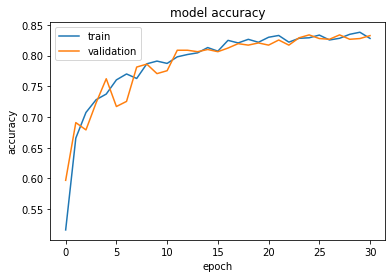

In [18]:
hist = model.fit(train_generator,
                 steps_per_epoch=len(train_generator),
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=len(val_generator),
                 callbacks=[cb_checkpointer, cb_early_stopper, cb_plateau],
                 verbose = 1)

plot_hist(hist)

# BEST RESULT --> 299/299 [==============================] - 79s 263ms/step - loss: 0.3927 - accuracy: 0.8253 - val_loss: 0.3919 - val_accuracy: 0.8264

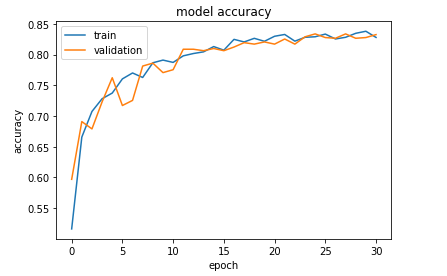

# Training (2 - Partially Unlocked)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 3,948,573
Non-trainable params: 104,841
_________________________________________________________________
Epoch 1/100
299/299 [==============================] - 82s 273ms/step - loss: 0.4123 - accuracy: 0.8234 - val_loss: 0.3658 - val_accuracy: 0.8347
Epoch 2/100
299/299 [==============================] - 81s 270ms/step - loss: 0.3646 - acc

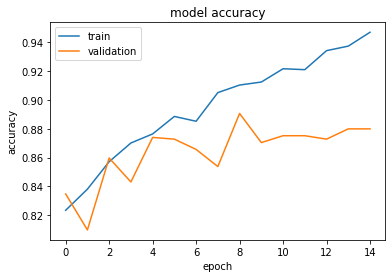

In [19]:
model.load_weights(name + ".hdf5")

train_after_layer = 74
learning_rate = 1e-4

for layer in base_model.layers[train_after_layer:]:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.DepthwiseConv2D):
        layer.trainable = True

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

hist = model.fit(train_generator,
                 steps_per_epoch=len(train_generator),
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=len(val_generator),
                 callbacks=[cb_checkpointer, cb_early_stopper, cb_plateau],
                 verbose = 1)

plot_hist(hist)

#BEST -> 299/299 [==============================] - 84s 279ms/step - loss: 0.2261 - accuracy: 0.9103 - val_loss: 0.3041 - val_accuracy: 0.8906

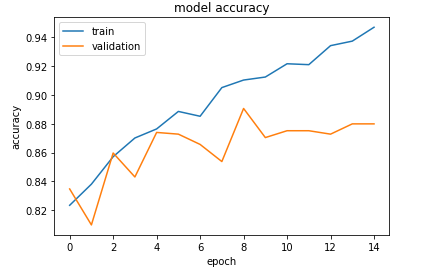

# Training (3 - Unlocked)

In [ ]:
model.load_weights(name + ".hdf5")

learning_rate = 1e-5

for layer in base_model.layers:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.DepthwiseConv2D):
        layer.trainable = True

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

hist = model.fit(train_generator,
                 steps_per_epoch=len(train_generator),
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=len(val_generator),
                 callbacks=[cb_checkpointer, cb_early_stopper, cb_plateau],
                 verbose = 1)

plot_hist(hist)

# Testing and Creating CSV

In [ ]:
model.load_weights(name + ".hdf5")

test_dir = os.path.join(cwd, 'test')

test_data_gen = ImageDataGenerator(preprocessing_function=preprocessing)

test_gen = test_data_gen.flow_from_directory(test_dir, target_size=(img_h, img_w),
                                             color_mode='rgb',
                                             class_mode='categorical',
                                             classes = None,
                                             batch_size=1,
                                             shuffle=False)
test_gen.reset()

predictions = model.predict(test_gen, verbose=1)

results = {}

images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, cwd)